In [1]:
#  %pip install --upgrade xarray numpy matplotlib pandas seaborn

In [2]:
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import external packages
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Add path with self-created packages and import them
import sys
sys.path.append('./src')
import sciebo

# Wheel Speed Analysis with Pandas and Seaborn 

In the experiment reported by [Steinmetz et al, 2019 in Nature](https://www.nature.com/articles/s41586-019-1787-x), the mice perform a discrimination task where that had to find out which stimuli (left vs right) has the higher contrast. And they report their decision by steering a wheel such that the stimuli with the higher contrast moves to the center screen.

##### Analysis Goals
In this notebook we will be analyzing the speed at which the mouse turned the wheel to report their decision.

##### Learning Goals
First, we will be exploring the [**Xarray**](https://docs.xarray.dev/) Python package to load the data files in `.nc` (i.e. netCDF) format. We then will continue our exploration of the [**Pandas**](https://pandas.pydata.org/) and [**Seaborn**](https://seaborn.pydata.org/) Python packages to visualise and analyse this data.

---

#### Download Dataset

This data has been pre-processed from Steinmetz and al 2019, and is hosted on Sciebo: https://uni-bonn.sciebo.de/s/Y8C1TJcuk1GFg3V.  The code below should download one of the files (i.e. "steinmetz_2016-12-14_Cori.nc") to the folder `data`.

In [3]:
sciebo.download_from_sciebo('https://uni-bonn.sciebo.de/s/qmuIZfZC2bRe2iR', 'data/steinmetz_2016-12-14_Cori.nc')

---

## XArray Datasets: From netCDF files to pandas DataFrames

We will first explore a new file format: the **NetCDF** format, which is great for handling big, complicated data easily. Unlike a CSV file, which is like a basic spreadsheet, a netCDF file not only holds your data but also can contain the metadata explaining what the data is about. This is quite useful when you're dealing with lots of numbers and measurements.

**xarray**

| Code               | Description                                                                                                  |
|--------------------|--------------------------------------------------------------------------------------------------------------|
| `dset = xr.load_dataset()`| Loads a dataset from a specified file path using the xarray library, ideal for multi-dimensional data arrays. |
| `dset["variable_name"]`   | Extracts a single variable from the dataset using indexing.                                                   |
| `dset["variable_name"].to_dataframe()`     | Creates a Pandas DataFrame from the selected variable, for familiar data manipulation and analysis.   |

Let's start by load the file we download using the `xarray` library. 

In [3]:
dataset = xr.load_dataset('data/steinmetz_2016-12-14_Cori.nc')
dataset

<xarray.Dataset>
Dimensions:         (mouse: 1, session_date: 1, trial: 364, time: 250, cell: 734)
Coordinates:
  * mouse           (mouse) object 'Cori'
  * session_date    (session_date) object '2016-12-14'
  * trial           (trial) int64 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
  * time            (time) float64 0.01 0.02 0.03 0.04 ... 2.47 2.48 2.49 2.5
  * cell            (cell) int64 1 2 3 4 5 6 7 8 ... 728 729 730 731 732 733 734
Data variables: (12/24)
    contrast_left   (mouse, session_date, trial) int8 100 0 100 0 ... 0 25 100
    contrast_right  (mouse, session_date, trial) int8 0 50 50 0 ... 25 50 0 100
    gocue           (mouse, session_date, trial) float64 1.027 0.8744 ... nan
    stim_onset      (mouse, session_date, trial) float64 0.5 0.5 0.5 ... 0.5 0.5
    feedback_type   (mouse, session_date, trial) float64 1.0 1.0 1.0 ... nan nan
    feedback_time   (mouse, session_date, trial) float64 1.187 1.438 ... nan nan
    ...              ...
    spks            (mouse, session_date, cell, trial, time) int8 0 0 0 ... 0 0
    trough_to_peak  (mouse, session_date, cell) int8 19 19 10 17 ... 16 8 20 10
    ccf_ap          (mouse, session_date, cell) float64 4.09e+03 ... 8.914e+03
    ccf_dv          (mouse, session_date, cell) float64 2.445e+03 ... 4.094e+03
    ccf_lr          (mouse, session_date, cell) float64 5.012e+03 ... 3.021e+03
    brain_area      (mouse, session_date, cell) object 'ACA' 'MOs' ... 'DG'
Attributes:
    bin_size:    0.01
    stim_onset:  0.5

The movement of the wheel is only recorded during "active trials". Hence we use the `where(condition)` method of the Xarray DataSet to *drop* all datapoints where the value of `active_trial` is not 1. 

In [23]:
x = dataset['wheel'].to_dataframe().reset_index().set_index(['time', 'trial'])
x['wheel'].unstack().stack().reset_index(name='wheel')

,time,trial,wheel
0,0.01,1,-1
1,0.01,2,0
2,0.01,3,0
3,0.01,4,0
4,0.01,5,0
...,...,...,...
90995,2.50,360,0
90996,2.50,361,0
90997,2.50,362,0
90998,2.50,363,0


In [5]:
dataset = dataset.where(dataset.active_trials==1 , drop=True)
dataset

<xarray.Dataset>
Dimensions:         (mouse: 1, session_date: 1, trial: 214, time: 250, cell: 734)
Coordinates:
  * mouse           (mouse) object 'Cori'
  * session_date    (session_date) object '2016-12-14'
  * trial           (trial) int64 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214
  * time            (time) float64 0.01 0.02 0.03 0.04 ... 2.47 2.48 2.49 2.5
  * cell            (cell) int64 1 2 3 4 5 6 7 8 ... 728 729 730 731 732 733 734
Data variables: (12/24)
    contrast_left   (mouse, session_date, trial) float32 100.0 0.0 ... 25.0 25.0
    contrast_right  (mouse, session_date, trial) float32 0.0 50.0 ... 100.0
    gocue           (mouse, session_date, trial) float64 1.027 0.8744 ... 0.986
    stim_onset      (mouse, session_date, trial) float64 0.5 0.5 0.5 ... 0.5 0.5
    feedback_type   (mouse, session_date, trial) float64 1.0 1.0 ... -1.0 -1.0
    feedback_time   (mouse, session_date, trial) float64 1.187 1.438 ... 1.474
    ...              ...
    spks            (mouse, session_date, cell, trial, time) float32 0.0 ... 0.0
    trough_to_peak  (mouse, session_date, cell, trial) float32 19.0 ... 10.0
    ccf_ap          (mouse, session_date, cell, trial) float64 4.09e+03 ... 8...
    ccf_dv          (mouse, session_date, cell, trial) float64 2.445e+03 ... ...
    ccf_lr          (mouse, session_date, cell, trial) float64 5.012e+03 ... ...
    brain_area      (mouse, session_date, cell, trial) object 'ACA' ... 'DG'
Attributes:
    bin_size:    0.01
    stim_onset:  0.5

**Note** that now the number of trials is lower. Let's now continue by getting a better understanding of the Xarrat dataset.

While you can interactively explore the variables that are available in this dataset, you can also view the variables using the `data_vars` attribute:

In [6]:
dataset.data_vars

Data variables:
    contrast_left   (mouse, session_date, trial) float32 100.0 0.0 ... 25.0 25.0
    contrast_right  (mouse, session_date, trial) float32 0.0 50.0 ... 100.0
    gocue           (mouse, session_date, trial) float64 1.027 0.8744 ... 0.986
    stim_onset      (mouse, session_date, trial) float64 0.5 0.5 0.5 ... 0.5 0.5
    feedback_type   (mouse, session_date, trial) float64 1.0 1.0 ... -1.0 -1.0
    feedback_time   (mouse, session_date, trial) float64 1.187 1.438 ... 1.474
    response_type   (mouse, session_date, trial) float64 1.0 -1.0 ... 0.0 1.0
    response_time   (mouse, session_date, trial) float64 1.15 1.4 ... 2.278 1.47
    reaction_type   (mouse, session_date, trial) float64 1.0 -1.0 ... 0.0 1.0
    reaction_time   (mouse, session_date, trial) float64 170.0 ... 1.35e+03
    prev_reward     (mouse, session_date, trial) float64 -10.0 -4.733 ... -2.639
    active_trials   (mouse, session_date, trial) float64 1.0 1.0 1.0 ... 1.0 1.0
    wheel           (mouse, sessi

**Exercies:**

Let's explore the dataset we loaded using the Xarray Python package and see how we can turn them into Pandas DataFrames.

**Example:** Similar to Pandas DataFrame, we can also use the indexing (using `[]`) with variable names to extract a single variable (or multiple variables) from the dataset:

In [7]:
dataset["contrast_left"]

<xarray.DataArray 'contrast_left' (mouse: 1, session_date: 1, trial: 214)>
array([[[100.,   0., 100.,   0.,  50.,   0.,   0.,   0.,   0., 100.,
          50.,   0.,  50., 100.,  50.,   0.,   0., 100.,   0.,   0.,
           0.,   0.,   0.,   0.,  50.,   0.,   0.,   0.,  50.,  25.,
          25.,   0., 100.,  50.,   0.,   0.,   0.,   0.,  50.,  25.,
         100.,   0.,   0.,   0.,   0.,   0.,   0.,  50.,  25.,  50.,
           0.,   0.,   0., 100.,  50.,  50.,   0.,   0.,   0.,  50.,
          25.,   0.,   0.,   0., 100.,   0.,  25.,   0.,   0.,   0.,
         100.,   0., 100.,  50.,   0., 100., 100.,   0.,   0.,   0.,
          25.,  25.,  25.,   0., 100.,  50.,   0.,  50.,   0.,  50.,
         100.,  25.,  50.,  50.,   0., 100.,   0.,  25.,  25.,  25.,
          25., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          25.,  25.,  25.,  25.,  25.,   0.,  50.,  50.,   0.,  50.,
           0.,  50.,   0., 100.,  25., 100.,   0.,  25., 100.,   0.,
           0.,   0.,   0.,   0.,   0.,  25.,   0.,  50.,   0.,   0.,
         100.,  50.,   0.,  25.,  50.,   0.,  25.,  50.,   0.,  50.,
         100.,   0., 100.,   0.,   0., 100.,  50.,   0.,   0.,  25.,
           0., 100.,   0.,   0.,   0.,  50., 100., 100.,  25.,  25.,
          25.,  25.,  25.,  25.,  25.,  25.,  50., 100.,   0.,  50.,
         100., 100.,   0.,  50.,   0.,   0.,   0.,  25.,   0.,  50.,
         100.,  25.,  50., 100.,  50., 100., 100., 100.,  25.,   0.,
          25.,   0.,   0.,   0.,   0.,  25.,  25.,  25.,  25.,  25.,
          25.,  25.,  25.,  25.]]], dtype=float32)
Coordinates:
  * mouse         (mouse) object 'Cori'
  * session_date  (session_date) object '2016-12-14'
  * trial         (trial) int64 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214

Select only the `response_time` variable from the dataset.

In [8]:
dataset["response_time"]

<xarray.DataArray 'response_time' (mouse: 1, session_date: 1, trial: 214)>
array([[[1.15020363, 1.39950287, 0.94929105, 2.26680167, 0.81677584,
         1.51710695, 1.13321043, 1.34983104, 2.09712508, 1.24966756,
         0.85012552, 2.68711772, 1.11656384, 1.33318552, 1.16616737,
         0.63355482, 2.25236982, 2.26686564, 1.0334353 , 1.50068597,
         2.55500321, 1.11652772, 1.88402217, 2.45124877, 1.16664193,
         1.20006031, 2.03322566, 1.28394722, 1.00076718, 0.65046396,
         1.46640514, 2.06899863, 1.26769545, 0.96801046, 1.31672231,
         1.9945947 , 2.04642421, 1.21717001, 1.15041613, 1.20058137,
         0.58430745, 1.48373157, 1.08377657, 1.61696393, 2.0249377 ,
         0.63468075, 1.31750766, 0.85095507, 0.68352361, 1.21828197,
         1.97045611, 1.11797797, 2.1441927 , 1.23396189, 0.63466365,
         1.1342873 , 1.66770751, 1.55014191, 0.68371489, 1.30129107,
         1.20153896, 1.15070234, 2.48842292, 1.45103799, 0.70175933,
         1.53410517, 1.98478822, 2.43346185, 1.36750195, 2.14922358,
         0.90154979, 1.03394011, 0.75082235, 1.38440318, 1.31853061,
         0.66763416, 0.81730739, 1.01777675, 0.95186767, 2.01481996,
         2.16295917, 0.951785  , 2.31831362, 0.70186012, 1.21846907,
         2.56933478, 2.36544238, 0.65215477, 1.33471536, 1.16827375,
         1.03429643, 1.1177492 , 0.98402039, 2.60262985, 1.33511192,
         1.01833607, 1.61876251, 2.03657985, 1.03549279, 2.08261646,
...
         2.35098914, 1.05186252, 1.1185011 , 2.56118677, 1.01803181,
         2.31229221, 0.70242317, 1.10209811, 0.90252518, 0.71840183,
         0.93584123, 1.45237904, 1.38516144, 0.61852045, 2.3861482 ,
         1.56961416, 2.68969916, 1.45256865, 0.70279907, 0.93506685,
         2.59396324, 2.327756  , 1.15257383, 2.06976685, 1.9019081 ,
         0.85202689, 1.1854737 , 1.185336  , 1.46938694, 1.38519073,
         2.29048794, 2.64857895, 0.96907101, 2.57194321, 1.30267954,
         0.60248425, 2.06512489, 0.78643812, 1.35222821, 2.21893247,
         1.18600374, 1.05299063, 1.10255957, 2.22489538, 2.10339131,
         2.484936  , 0.83666437, 1.38665617, 2.40198164, 1.40349786,
         0.80234024, 0.95227579, 0.93658128, 2.0173672 , 2.2502767 ,
         2.54410835, 2.05736356, 1.20267983, 2.25279582, 2.25601015,
         1.63615021, 1.11910924, 1.22005873, 0.76927693, 2.28897715,
         2.03377454, 1.20255644, 2.46739445, 2.47640064, 2.03268765,
         2.1366013 , 2.40449933, 1.33653057, 2.4957271 , 1.31959108,
         1.51888291, 2.09079068, 2.21788565, 2.6024248 , 2.53051174,
         2.13620147, 2.15035791, 1.1875331 , 2.385321  , 2.64788938,
         1.53622496, 2.49997079, 2.21305111, 2.13048579, 2.47970035,
         1.85346734, 1.87038007, 2.11380656, 1.46960651, 1.45313702,
         1.22035868, 2.30621361, 2.27786071, 1.47038149]]])
Coordinates:
  * mouse         (mouse) object 'Cori'
  * session_date  (session_date) object '2016-12-14'
  * trial         (trial) int64 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214

Using the `.to_dataframe()` method create a Pandas DataFrame from `dataset["response_time"]`.

In [9]:
dataset["response_time"].to_dataframe()

response_time
mouse session_date trial               
Cori  2016-12-14   1           1.150204
                   2           1.399503
                   3           0.949291
                   4           2.266802
                   5           0.816776
...                                 ...
                   210         1.453137
                   211         1.220359
                   212         2.306214
                   213         2.277861
                   214         1.470381

[214 rows x 1 columns]

Use the `.reset_index()` on the resulting dataframe to expand the all index columns (e.g. `mouse` and `session_date`) across all rows.

In [10]:
dataset["response_time"].to_dataframe().reset_index()

,mouse,session_date,trial,response_time
0,Cori,2016-12-14,1,1.150204
1,Cori,2016-12-14,2,1.399503
2,Cori,2016-12-14,3,0.949291
3,Cori,2016-12-14,4,2.266802
4,Cori,2016-12-14,5,0.816776
...,...,...,...,...
209,Cori,2016-12-14,210,1.453137
210,Cori,2016-12-14,211,1.220359
211,Cori,2016-12-14,212,2.306214
212,Cori,2016-12-14,213,2.277861


Using the methods we used above, create a Pandas Dataframe for the wheel speed data (variable name is `wheel`). Let's call it `wheel_df`.

The resulting DataFrame will look similar to the following:
| mouse | session_date | trial | time | wheel |
|-------|--------------|-------|------|-------|
| Cori  | 2016-12-14   | 1     | 0.01 | -1.0  |
| Cori  | 2016-12-14   | 1     | 0.02 | 0.0   |
| Cori  | 2016-12-14   | 1     | 0.03 | 0.0   |
| Cori  | 2016-12-14   | 1     | 0.04 | 0.0   |
| Cori  | 2016-12-14   | 1     | 0.05 | 0.0   |
| ...  | ...  | ...     | ... | ...  |

In [11]:
wheel_df = dataset["wheel"].to_dataframe().reset_index()
wheel_df

,mouse,session_date,trial,time,wheel
0,Cori,2016-12-14,1,0.01,-1.0
1,Cori,2016-12-14,1,0.02,0.0
2,Cori,2016-12-14,1,0.03,0.0
3,Cori,2016-12-14,1,0.04,0.0
4,Cori,2016-12-14,1,0.05,0.0
...,...,...,...,...,...
53495,Cori,2016-12-14,214,2.46,3.0
53496,Cori,2016-12-14,214,2.47,2.0
53497,Cori,2016-12-14,214,2.48,2.0
53498,Cori,2016-12-14,214,2.49,3.0


---

## Visualizing Wheel Speed with Seaborn

In this section we will use the [**Seaborn**](https://seaborn.pydata.org/) plotting library to visualize the speed at which the mouse turned the wheel in every trial. Not only Seaborn is designed to work well with Pandas DataFrames, but it also produces informative and good-looking plots with a minimal code.   

The experimental data contains the wheel speed over time, across all trials. A positive turning speed means that the wheel is being moved to the right, while a negative speed tells us the wheel is being moved to the left. When the wheel is not being moved at all, the turning speed is zero.

Let's visualise this data using line plots from the Seaborn library.


**pandas**

| Code                      | Description                                      |
|---------------------------|--------------------------------------------------|
| `df['column_name']`       | accessing individual columns.                     |
| `df.reset_index()`        | Resets the index of the DataFrame, making it sequential. |
| `df.set_index(new_index)` | Sets the index of the DataFrame to `new_index`.  |
| `df.unstack()`            | Pivots a level of the index labels to the columns, reshaping the DataFrame. |
| `df.stack()`              | Pivots a level of the column labels to the index, reshaping the DataFrame. |

**seaborn** 

| Code                                          | Description                                   |
| --------------------------------------------- | --------------------------------------------- |
| `sns.lineplot(data)`                          | Plot data as a line.      |
| `sns.lineplot(data, label='my_label')`        | Show a legend label associated with data.     |
| `sns.lineplot(data, color='blue')`            | Plot a line in blue.                          |
| `sns.lineplot(data, linestyle='dotted')`      | Plot a dotted line.                           |

Before we start visualizing the wheel speed, let's restructure our `wheel_df` such that it becomes a bit easier to analyse. Let's change the dataframe such that as indices we have `time` and as columns we have `trial`:

Set `time` and `trial` both as indices of the `wheel_df`, using `.set_index()` method.

In [12]:
wheel_df_indexed = wheel_df.set_index(['time', 'trial'])
wheel_df_indexed

,,mouse,session_date,wheel
time,trial,,,
0.01,1,Cori,2016-12-14,-1.0
0.02,1,Cori,2016-12-14,0.0
0.03,1,Cori,2016-12-14,0.0
0.04,1,Cori,2016-12-14,0.0
0.05,1,Cori,2016-12-14,0.0
...,...,...,...,...
2.46,214,Cori,2016-12-14,3.0
2.47,214,Cori,2016-12-14,2.0
2.48,214,Cori,2016-12-14,2.0


Use `[]` to select the `"wheel"` column, and apply the `.unstack()` method.

In [13]:
wheel_df = wheel_df_indexed["wheel"].unstack()
wheel_df

trial,1,2,3,4,5,6,7,8,9,10,...,205,206,207,208,209,210,211,212,213,214
time,,,,,,,,,,,,,,,,,,,,,
0.01,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0.03,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.04,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.46,0.0,0.0,0.0,0.0,-7.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,-1.0,0.0,-1.0,3.0,2.0,0.0,0.0,3.0
2.47,0.0,0.0,0.0,0.0,-6.0,2.0,0.0,0.0,1.0,1.0,...,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0
2.48,1.0,1.0,-1.0,0.0,-6.0,2.0,0.0,0.0,0.0,0.0,...,0.0,5.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0


**Exercises**

**Example:** Use a line plot to plot the wheel speed for trial 7.

<Axes: xlabel='time', ylabel='7'>

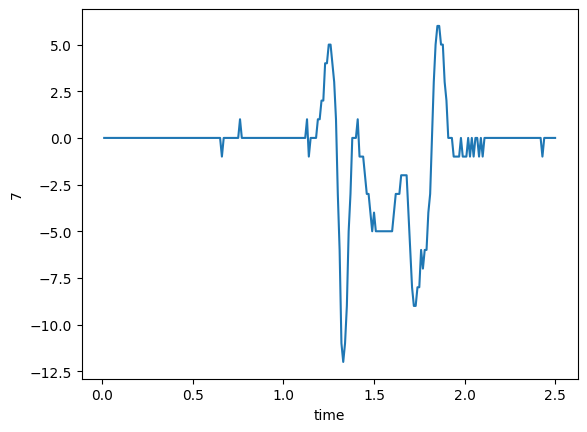

In [14]:
sns.lineplot(wheel_df[7])

Use a line plot to plot the wheel speed for trial 17.

<Axes: xlabel='time', ylabel='17'>

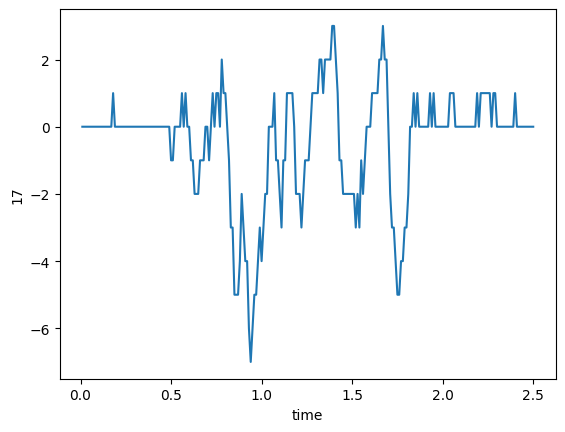

In [15]:
sns.lineplot(wheel_df[17])

Create a line plot for the wheel speed in two different trials (e.g. trial 9 and 21) by calling the plotting function twice.

<Axes: xlabel='time', ylabel='9'>

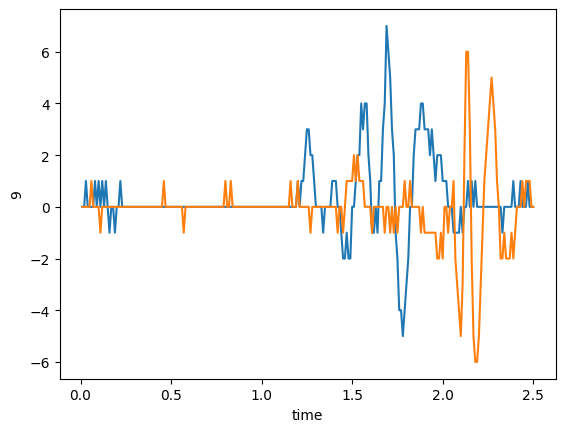

In [16]:
sns.lineplot(wheel_df[9])
sns.lineplot(wheel_df[21])

Let's now explore some of the other arguments that we can pass into the `sns.lineplot()` function to change the style of the plot or add more information to it (e.g. a legend).

Recreate the plot above where one trial is shown as a dotted line.

<Axes: xlabel='time', ylabel='9'>

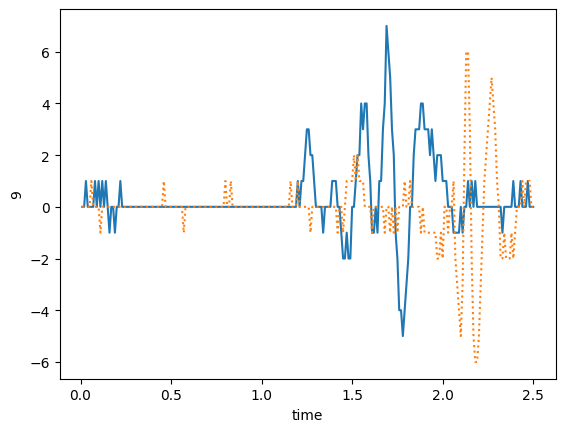

In [17]:
sns.lineplot(wheel_df[9])
sns.lineplot(wheel_df[21], linestyle='dotted')

Recreate the plot above, this time adding a legend to the plot. **Hint:** specify a `label` for each line plot.

<Axes: xlabel='time', ylabel='9'>

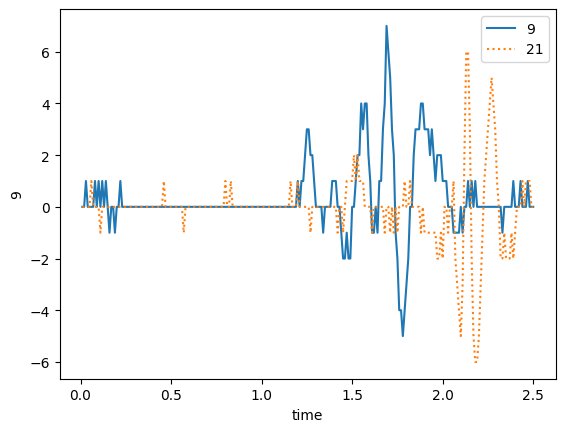

In [18]:
sns.lineplot(wheel_df[9], label=9)
sns.lineplot(wheel_df[21], label=21, linestyle='dotted')

Plot three trials, where each trial has the same line color but a different linestyle

<Axes: xlabel='time', ylabel='9'>

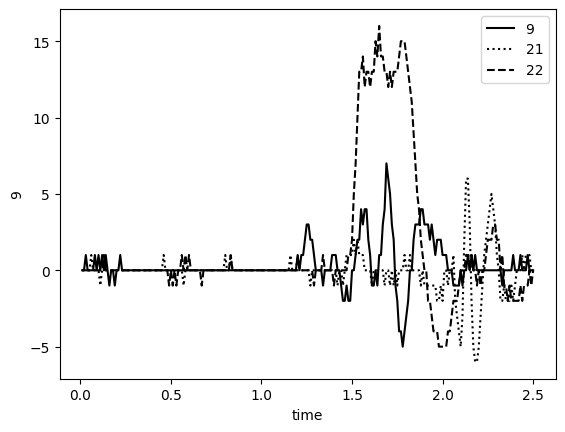

In [19]:
sns.lineplot(wheel_df[9], label=9, color='black', linestyle='solid')
sns.lineplot(wheel_df[21], label=21, color='black', linestyle='dotted')
sns.lineplot(wheel_df[22], label=22, color='black', linestyle='dashed')

Plot three trials, where each trial has a different line color but the same linestyle

<Axes: xlabel='time', ylabel='9'>

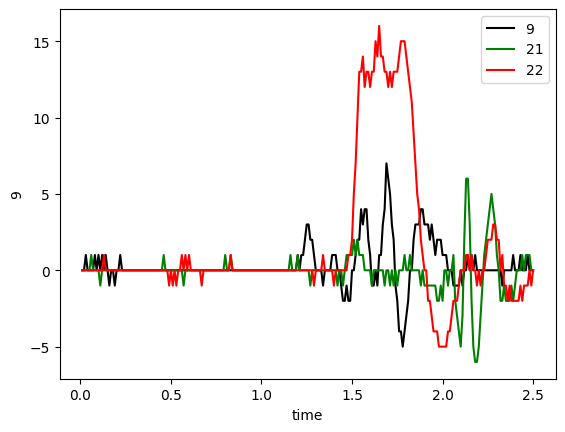

In [20]:
sns.lineplot(wheel_df[9], label=9, color='black', linestyle='solid')
sns.lineplot(wheel_df[21], label=21, color='green', linestyle='solid')
sns.lineplot(wheel_df[22], label=22, color='red', linestyle='solid')

Instead of using a single value to select a specific trial, we can specify a list of trial numbers using `[]`, and plot all of them at the same time. 

**Example:** Plot wheel speed for trials 9, 34, and 21.

<Axes: xlabel='time'>

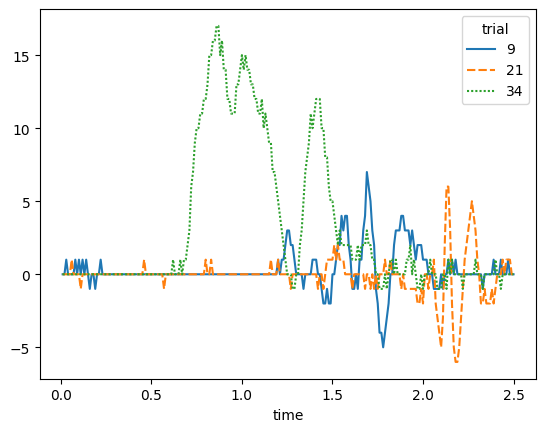

In [21]:
sns.lineplot(wheel_df[[9, 34, 21]])

And now let's plot the wheel speeds for all trials. **Hint:** pass the argument `legend=None` to `lineplot` to hide the legend.

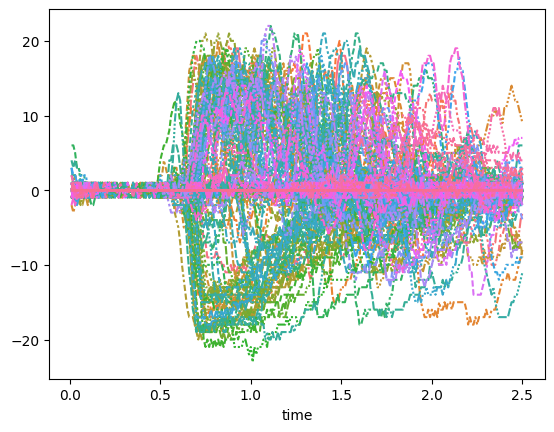

In [22]:
sns.lineplot(wheel_df, legend=None);

Remake the above plot changing the opacity of the lines. **Hint:** `lineplot` has an argument `alpha` that takes values between 0 and 1. 

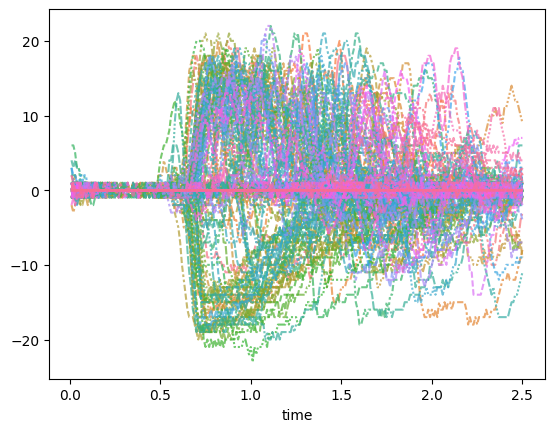

In [23]:
sns.lineplot(wheel_df, legend=None, alpha=0.7);

Experiment with the `alpha` value to find which value best displays the lines.

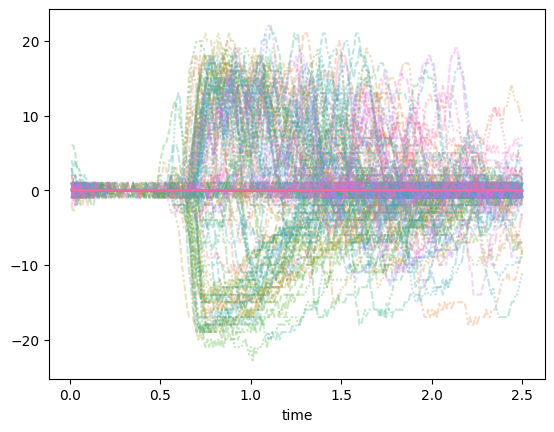

In [24]:
sns.lineplot(wheel_df, legend=None, alpha=0.3);

**BONUS** This looks overplotted! Instead we can make a heatmap, which shows how many datapoints are in a region of the plot.

Here is the idea: we want to change the line plot essentially to a 2d histogram: one dimension is time, and the other wheel speed, the count is basically how many times every combination of these two variables happened in the dataset.

Here are the steps:

1. we are going to bin the the columns that correspond to the line plot, namely time and wheel speed
2. then we will chunck our dataframe for unique combination of these two bins
3. we will count the number of entries for each chunck

Pandas and seaborn give us all the tools we need for this:

In [25]:
# first we need to make both time and wheel to be a single column
wheel_df_reset_index = wheel_df.stack().reset_index(name="wheel")
wheel_df_reset_index

,time,trial,wheel
0,0.01,1,-1.0
1,0.01,2,0.0
2,0.01,3,0.0
3,0.01,4,0.0
4,0.01,5,0.0
...,...,...,...
53495,2.50,210,1.0
53496,2.50,211,1.0
53497,2.50,212,0.0
53498,2.50,213,0.0


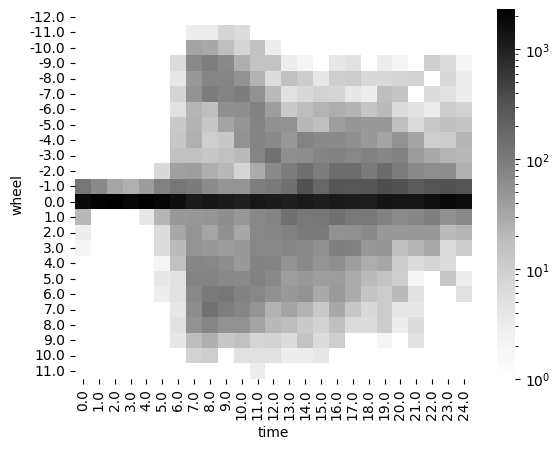

In [26]:
time_bin_size = .1
wheel_bin_size = 2

time_bin_index = wheel_df_reset_index['time'] // time_bin_size
wheel_bin_index = wheel_df_reset_index['wheel'] // wheel_bin_size
sns.heatmap(wheel_df_reset_index.groupby([wheel_bin_index, time_bin_index]).size().unstack(fill_value=0), norm=LogNorm(), cmap=plt.cm.Greys,);

What happens when you change the bin size for time and/or for the wheel speed?


---

## Describing Data with Metrics: Determining Turning Direction

Data analysis is all about making sense of data. Statistics like averages is one example of this. Such measures can help us minimise the amount of data that we need to think about and allow to answer more generic questions. In the context of the wheel speed data that we have been working on so far, a natural question is: **which way did the subject turn the wheel?**

In this section, we will be using aggregation methods such as `.mean()` combined with filtering to further analyze the wheel speed data for instance to only look at trials in which the wheel was turned to the left.

**Pandas**

| Code                             | Description                                                      |
| -------------------------------- | ---------------------------------------------------------------- |
| `df.mean()`                      | Calculate the mean of every column of a dataframe.               |
| `df[df < 0]`                     | Filtering based on a condition, suitable for a Pandas Series.    |
| `df[["column1", "column2"]]`     | Select multiple specific columns from a dataframe.               |
| `len(df)`                        | Count the number of rows in a dataframe.                         | 

Let's start by re-creating the `wheel_df` using the methods we used earlier in this notebook:

In [27]:
wheel_df = dataset['wheel'].to_dataframe().reset_index().set_index(['time', 'trial'])['wheel'].unstack()
wheel_df

trial,1,2,3,4,5,6,7,8,9,10,...,205,206,207,208,209,210,211,212,213,214
time,,,,,,,,,,,,,,,,,,,,,
0.01,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0.03,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.04,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.46,0.0,0.0,0.0,0.0,-7.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,-1.0,0.0,-1.0,3.0,2.0,0.0,0.0,3.0
2.47,0.0,0.0,0.0,0.0,-6.0,2.0,0.0,0.0,1.0,1.0,...,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0
2.48,1.0,1.0,-1.0,0.0,-6.0,2.0,0.0,0.0,0.0,0.0,...,0.0,5.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0


**Exercises**

Calculate the mean wheel speed for each trial from `wheel_df`. Name the result `mean_wheel_speeds`.

In [28]:
mean_wheel_speeds = wheel_df.mean()
mean_wheel_speeds

trial
1      4.376
2     -2.944
3      2.616
4     -0.268
5      2.532
       ...  
210    1.268
211    2.364
212   -0.004
213   -0.008
214    0.476
Length: 214, dtype: float32

In the next few steps, we will use `mean_wheel_speeds` and `wheel_df` to visualize the trials that the average wheel speed was greater that 0.

First, identify the trial numbers where the mean wheel speed is greater than 0. **Hint:** the index of `mean_wheel_speeds` is the trial number.

In [29]:
selected_trials = mean_wheel_speeds[mean_wheel_speeds > 0].index
selected_trials

Index([  1,   3,   5,   6,   9,  10,  11,  13,  14,  15,
       ...
       201, 202, 203, 205, 206, 207, 209, 210, 211, 214],
      dtype='int64', name='trial', length=116)

How many trials have a mean wheel speed greater than 0?

In [30]:
len(selected_trials)

116

Now that we have the trial numbers where the wheel speed was positive on average:
1. use it to index the corresponding columns of our `wheel_df` dataframe
2. plot the wheel speed for the these trials. **Sanity check:** the lines should mostly be above 0

<Axes: xlabel='time'>

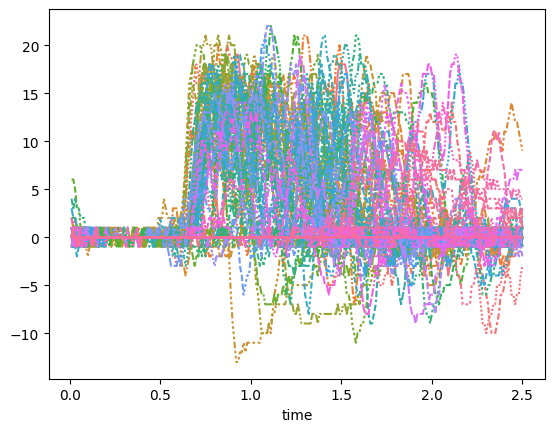

In [31]:
sns.lineplot(wheel_df[selected_trials], legend=None)

Find the number of trials where the mean wheel speed is less than 0.

In [32]:
len(mean_wheel_speeds[mean_wheel_speeds < 0])

90

Find the number of trials where the mean wheel speed is 0.

In [33]:
len(mean_wheel_speeds[mean_wheel_speeds == 0])

8

Let's now try the same analysis, but this time Instead we will find trials whose maximum wheel speed is greater than 10.
Determine the maximum wheel speed for each trial. Call this `max_wheel_speeds`.


In [34]:
max_wheel_speeds = wheel_df.max()
max_wheel_speeds

trial
1      19.0
2       5.0
3      14.0
4       7.0
5      18.0
       ... 
210     9.0
211    10.0
212     1.0
213     1.0
214    12.0
Length: 214, dtype: float32

Find the trials numbers where the maximum wheel speed is greater than 10.

In [35]:
selected_trials = max_wheel_speeds[max_wheel_speeds > 10].index
selected_trials

Index([  1,   3,   5,   6,  10,  11,  12,  13,  14,  15,  19,  22,  23,  25,
        26,  29,  30,  34,  40,  41,  44,  48,  49,  50,  54,  55,  56,  60,
        65,  67,  71,  73,  74,  76,  77,  82,  85,  86,  88,  90,  91,  92,
        93,  94,  96, 102, 103, 111, 117, 118, 120, 122, 124, 126, 129, 130,
       138, 141, 144, 148, 150, 151, 153, 156, 157, 162, 166, 167, 168, 173,
       177, 178, 179, 182, 190, 191, 198, 201, 207, 214],
      dtype='int64', name='trial')

Plot the wheel speeds of trials where the maximum wheel speed is greater than 10.

<Axes: xlabel='time'>

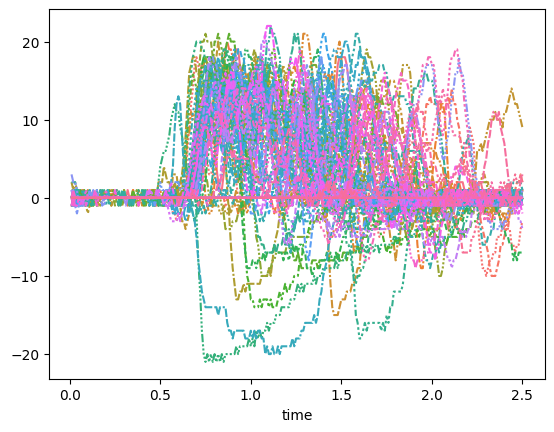

In [36]:
selected_data = wheel_df[selected_trials]
sns.lineplot(selected_data, legend=None)

How many trials have a maximum wheel speed greater than 10?

In [37]:
len(selected_trials)

80

---

## Result Validation using Python's Print Function

Python's `print` function is integral for outputting human-readable results. In this section we will use print statements to compare different metrics to determine the wheel turning direction, and produce cleanly formatted sentences

We have two metrics to determine the wheel turning direction:
* when the mean wheel speed is greater than 0 -> the wheel was turned to the right
* when the maximum turning speed is greater than 10 -> the wheel was turned to the right

Luckily, the authors have also provided information in the dataset that specifies when they considered the turn to be left, right, or no turn. This information is in the `response_type` variable. <br>
A `response_type` of:
- $ \ 1 \ \ : \ $ corresponds to a right turn
- $-1: \ $ corresponds to a left turn
- $ \ 0 \ \ : \ $  corresponds to no turning at all

Let's compare our metric for determining the turning directoin with the information provided by the authors.


**Python**

| Code                                                          | Description                                                      |
|---------------------------------------------------------------|------------------------------------------------------------------|
| `print(f"This is a formatted string with {variable}")`         | Print a string with variable value embedded.                     |
| `print("The mean speed is {:.2f}".format(mean_speed))`         | Print a string with a formatted floating-point number.          |

**Pandas**

| Code                                                          | Description                                                      |
|---------------------------------------------------------------|------------------------------------------------------------------|
| `df[df['column1'] == 8]`                                      | Filter dataframe rows based on a single condition.               |
| `df['column2'].isin(values)`                                  | Find rows of dataframe where column values are in a provided list of values.            |
| `df[(df['column2'] == 4) & (df['column1'] > 2)]`              | Filter dataframe based on multiple conditions.                   |

First, let's get the response types from the data.

In [38]:
response_df = dataset["response_type"].to_dataframe()
response_df = response_df.reset_index()
response_df

,mouse,session_date,trial,response_type
0,Cori,2016-12-14,1,1.0
1,Cori,2016-12-14,2,-1.0
2,Cori,2016-12-14,3,1.0
3,Cori,2016-12-14,4,0.0
4,Cori,2016-12-14,5,1.0
...,...,...,...,...
209,Cori,2016-12-14,210,1.0
210,Cori,2016-12-14,211,1.0
211,Cori,2016-12-14,212,0.0
212,Cori,2016-12-14,213,0.0


**Exercises**

**Example:** Print the value of variable `var_a` using format string.

In [39]:
var_a = 83
print(f'the value of my variable is {var_a}.')

the value of my variable is 83.


Print the number of trials where the mean speed is less than zero using format string.

In [40]:
num_trials_with_mean_less_than_zero = len(mean_wheel_speeds[mean_wheel_speeds<0])
print(f"The number of trials where the mean speed is less than zero is {num_trials_with_mean_less_than_zero}")

The number of trials where the mean speed is less than zero is 90


Print the number of trials where the mean speed is equal to zero.

In [41]:
num_trials_with_mean_equal_to_zero = len(mean_wheel_speeds[mean_wheel_speeds==0])
print(f"{num_trials_with_mean_equal_to_zero} trials had a mean speed of zero")

8 trials had a mean speed of zero


Print the percentage of trials where the mean speed is equal to zero.

In [42]:
print(f"{100*num_trials_with_mean_equal_to_zero/len(mean_wheel_speeds)} % of trials had a mean speed of zero")

3.7383177570093458 % of trials had a mean speed of zero


Are there too many decimal points in the number? We can apply rounding to 4 decimal places by writing the print statement like so:

```python
print(f"{my_variable:.4f}"`
```

Display the percentage of trials with zero mean speed rounded to 3 decimal places.

In [43]:
print(f"{100*num_trials_with_mean_equal_to_zero/len(mean_wheel_speeds):.3f} % of trials had a mean speed of zero")

3.738 % of trials had a mean speed of zero


Now let's move on to comparing the turning direction of our predictions with those of the dataset authors, Steinmetz et. al. We will be focusing on the **right turns**.

Find trials in `response_df` where `response_type` is 1 (that means wheel was turned to the right). Call this `steinmetz_trials`.

In [44]:
steinmetz_trials = response_df[response_df["response_type"]==1]['trial']
steinmetz_trials

0        1
2        3
4        5
5        6
9       10
      ... 
206    207
208    209
209    210
210    211
213    214
Name: trial, Length: 71, dtype: int64

In [45]:
mean_wheel_speeds[mean_wheel_speeds > 0].index

Index([  1,   3,   5,   6,   9,  10,  11,  13,  14,  15,
       ...
       201, 202, 203, 205, 206, 207, 209, 210, 211, 214],
      dtype='int64', name='trial', length=116)

Get the rows of `mean_wheel_speeds` where `mean_wheel_speeds.index` is in `steinmetz_trials`. These are the mean wheel speeds of trials where the dataset authors recorded a right turn of the wheel.

In [46]:
mean_wheel_speeds[mean_wheel_speeds.index.isin(steinmetz_trials)]

trial
1      4.376
3      2.616
5      2.532
6      0.940
10     4.276
       ...  
207    0.740
209    0.736
210    1.268
211    2.364
214    0.476
Length: 71, dtype: float32

If our approach of using the mean wheel speed is what the authors used, all the mean wheel speeds should now be greater than 0. Is that the case? 


Using a print statement describe the result, mentioning the percentage of the values that are greater than zero.

In [47]:
agreement = (mean_wheel_speeds[mean_wheel_speeds.index.isin(steinmetz_trials)] > 0).mean()
print(f"{100*agreement:.2f}% of the rows are positive.")

94.37% of the rows are positive.


Let's repeat the above analysis, but instead taking the other criteria where the maximum wheel speed is greater than 10. Is the closer to what authors might have used to identify right turns?

In [48]:
max_wheel_speeds = wheel_df.max()
agreement = (max_wheel_speeds[max_wheel_speeds.index.isin(steinmetz_trials)] > 10).mean()
print(f"{100*agreement:.2f}% of the rows are positive.")

90.14% of the rows are positive.
